In [2]:
import os
import shutil
import tempfile
import json
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import cv2

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    RandSpatialCropSamplesd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR,UNet,UNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    SmartCacheDataset,
)

import torch

print_config()

MONAI version: 1.0.1
Numpy version: 1.23.5
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0+cpu
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.

In [3]:
set_determinism(seed=0)
data_dir = 'C:\\Users\\Michael\\Documents\\post_knee_all\\'

In [4]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]

train_files_list = []
train_class = []
for i in range(num_class):
    train_files_list.extend(image_files[i])
    train_class.extend([i] * num_each[i])
num_total = len(train_class)
image_width, image_height = PIL.Image.open(train_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 8260
Image dimensions: 224 x 224
Label names: ['0', '1', '2', '3', '4']
Label counts: [3253, 1495, 2175, 1086, 251]


In [5]:
train_dic = []
for i in range(len(train_files_list)):
  train_dic.append({
      'image': train_files_list[i],
      'label': train_class[i]
  })

random.shuffle(train_dic)

In [6]:
train_len = int(len(train_dic)/10*8)
test_len = int(len(train_dic)/10*1)


In [7]:
train_dict = train_dic[:train_len]
test_dict = train_dic[train_len:train_len+test_len]
val_dict = train_dic[train_len+test_len:]

In [6]:
'''
#clahe pre-processing

for f in train_files_list:
    out = f.replace("archive", "post_knee")
    image = cv2.imread(f)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 5)
    final_img = clahe.apply(image_bw) 
    cv2.imwrite(out, final_img)
#clahe pre-processing
for f in val_files_list:
    out = f.replace("archive", "post_knee")
    image = cv2.imread(f)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 5)
    final_img = clahe.apply(image_bw) 
    cv2.imwrite(out, final_img)  
for f in test_files_list:
    out = f.replace("archive", "post_knee")
    image = cv2.imread(f)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 5)
    final_img = clahe.apply(image_bw) 
    cv2.imwrite(out, final_img)  
    '''

'\nimport cv2\n#clahe pre-processing\n\nfor f in train_files_list:\n    out = f.replace("archive", "post_knee")\n    image = cv2.imread(f)\n    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n    clahe = cv2.createCLAHE(clipLimit = 5)\n    final_img = clahe.apply(image_bw) \n    cv2.imwrite(out, final_img)\n#clahe pre-processing\nfor f in val_files_list:\n    out = f.replace("archive", "post_knee")\n    image = cv2.imread(f)\n    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n    clahe = cv2.createCLAHE(clipLimit = 5)\n    final_img = clahe.apply(image_bw) \n    cv2.imwrite(out, final_img)  \nfor f in test_files_list:\n    out = f.replace("archive", "post_knee")\n    image = cv2.imread(f)\n    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n    clahe = cv2.createCLAHE(clipLimit = 5)\n    final_img = clahe.apply(image_bw) \n    cv2.imwrite(out, final_img)  \n    '

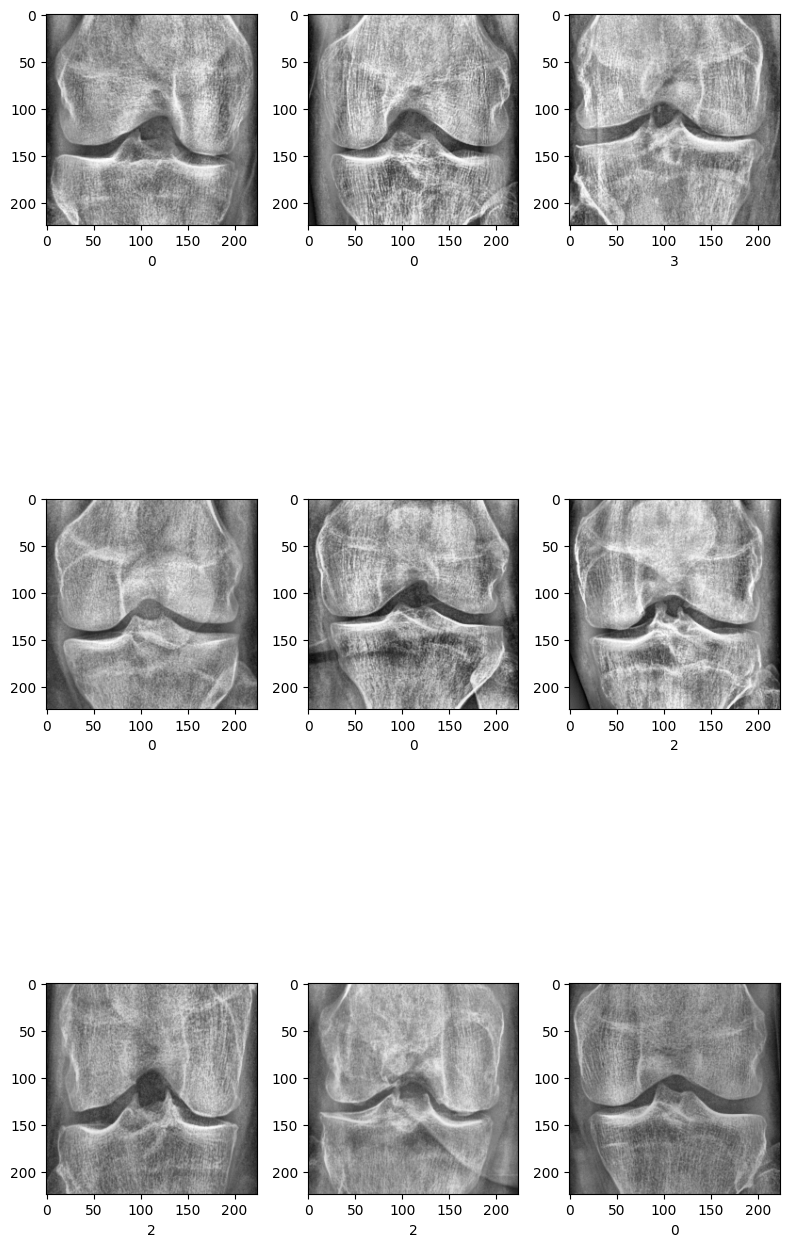

In [15]:
plt.subplots(3, 3, figsize=(8, 16))
for i, k in enumerate(np.random.randint(len(train_files_list), size=9)):
    im = PIL.Image.open(train_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[train_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys = ['image']),
        EnsureChannelFirstd(keys = ['image']),
        ScaleIntensityd(keys = ['image']),
        EnsureTyped(keys = ['image','label'],dtype = torch.float32),
  
        RandRotated(keys = ['image'],range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipd(keys = ['image'],spatial_axis=0, prob=0.5),
        RandZoomd(keys = ['image'],min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)


val_transforms = Compose(
    [ LoadImaged(keys = ['image']),
        EnsureChannelFirstd(keys = ['image']),
        ScaleIntensityd(keys = ['image']),
    
     EnsureTyped(keys = ['image','label'],dtype = torch.float32),
  
     
     ]
)

y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [131]:
train_ds = CacheDataset(data=train_dict, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(
    train_ds, batch_size=64,)#num_workers=10

Loading dataset: 100%|████████████████████████████████████████████████████████████| 6608/6608 [00:06<00:00, 948.15it/s]


In [9]:
val_ds = CacheDataset(data=val_dict, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=True)# num_workers=10

Loading dataset: 100%|██████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 853.71it/s]


In [3]:
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
class SSBR_vgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv6 = nn.Conv2d(
            512, 512, 1, stride=1, padding=0
        )  # in_channel, out_channel, kernel_size
        self.fc7 = nn.Linear(512, 1)
        self.model = self.get_vgg()

    def get_vgg(self):
        vgg16 = models.vgg16(pretrained=True)
        vgg16.features[0] = torch.nn.Conv2d(
            1, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        vgg16.to(device)

        return vgg16.features
    def forward(self, x: torch.Tensor):
        x = self.model(x.float())
        x = F.relu(self.conv6(x))
        x = torch.mean(x, axis=(2, 3))
        x = x.view(-1, 512)
        x = self.fc7(x)
        return x

class SSBR_efficientnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1280, 1)
        self.model = self.get_efficientnet()

    
    def get_efficientnet(self):
        efficientnet = models.efficientnet_v2_s(pretrained=True)
        efficientnet.features[0][0] = torch.nn.Conv2d(
            1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        return efficientnet
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 1280)
      x = self.fc7_res(x)
      return x


class SSBR_efficientnet_med(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1280, 1)
        self.model = self.get_efficientnet()
    
    def get_efficientnet(self):
        efficientnet = models.efficientnet_v2_m(pretrained=True)
        efficientnet.features[0][0] = torch.nn.Conv2d(
            1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        return efficientnet
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 1280)
      x = self.fc7_res(x)
      return x

class SSBR_densenet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1664, 1)
        self.model = self.get_densenet()
    
    def get_densenet(self):
        densenet169 = models.densenet169(pretrained=True)
        densenet169.features[0] = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        return densenet169.features
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = torch.mean(x, axis=(2, 3))
      x = x.view(-1, 1664)
      x = self.fc7_res(x)
      return x
class SSBR_resnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(2048, 1)
        self.model = self.get_resnet()
    
    def get_resnet(self):
        resnet50 = models.resnet50(pretrained=True)
        resnet50.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        resnet50 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
        return resnet50
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 2048)
      x = self.fc7_res(x)
      return x

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SSBR_efficientnet().to(device) 

C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model

SSBR_efficientnet(
  (fc7_res): Linear(in_features=1280, out_features=1, bias=True)
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1),

In [126]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
max_epochs = 50
val_interval = 1
auc_metric = ROCAUCMetric()
out_model ='C:\\Users\\Michael\\Documents\\post_knee\\test\\efficientnet_test.pth'


In [16]:

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data['image'].to(device), val_data['label'].to(device),
                y_out =model(val_images)                
                y_pred = torch.cat([y_pred, y_out], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_pred_rounded = torch.round(y_pred)
            y_pred_rounded[y_pred_rounded>4]=4
            y_pred_rounded[y_pred_rounded<0]=0
            absolute_error = torch.mean(torch.abs(y-y_pred))
            print(absolute_error)
            del absolute_error
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_trans(i) for i in decollate_batch(y_pred_rounded, detach=False)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred_rounded.squeeze(), y)
    
            acc_metric = acc_value.sum().item() / len(acc_value)
   
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), out_model)
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50
epoch 1 average loss: 0.9963
tensor(1.3366, device='cuda:0')
saved new best metric model
current epoch: 1 current AUC: 0.6658 current accuracy: 0.4419 best AUC: 0.6658 at epoch: 1
----------
epoch 2/50
epoch 2 average loss: 0.6348
tensor(1.3472, device='cuda:0')
saved new best metric model
current epoch: 2 current AUC: 0.6957 current accuracy: 0.4734 best AUC: 0.6957 at epoch: 2
----------
epoch 3/50
epoch 3 average loss: 0.5681
tensor(1.2670, device='cuda:0')
current epoch: 3 current AUC: 0.6553 current accuracy: 0.3390 best AUC: 0.6957 at epoch: 2
----------
epoch 4/50
epoch 4 average loss: 0.5247
tensor(1.4038, device='cuda:0')
current epoch: 4 current AUC: 0.6411 current accuracy: 0.3329 best AUC: 0.6957 at epoch: 2
----------
epoch 5/50
epoch 5 average loss: 0.5001
tensor(1.3333, device='cuda:0')
saved new best metric model
current epoch: 5 current AUC: 0.6996 current accuracy: 0.4903 best AUC: 0.6996 at epoch: 5
----------
epoch 6/50
epoch 6 average loss: 0.

epoch 46 average loss: 0.0927
tensor(1.2717, device='cuda:0')
current epoch: 46 current AUC: 0.7057 current accuracy: 0.5690 best AUC: 0.7799 at epoch: 29
----------
epoch 47/50
epoch 47 average loss: 0.0851
tensor(1.3232, device='cuda:0')
current epoch: 47 current AUC: 0.7619 current accuracy: 0.6077 best AUC: 0.7799 at epoch: 29
----------
epoch 48/50
epoch 48 average loss: 0.0839
tensor(1.3028, device='cuda:0')
current epoch: 48 current AUC: 0.7466 current accuracy: 0.5303 best AUC: 0.7799 at epoch: 29
----------
epoch 49/50
epoch 49 average loss: 0.0830
tensor(1.3071, device='cuda:0')
current epoch: 49 current AUC: 0.7715 current accuracy: 0.6005 best AUC: 0.7799 at epoch: 29
----------
epoch 50/50
epoch 50 average loss: 0.0826
tensor(1.3165, device='cuda:0')
current epoch: 50 current AUC: 0.7455 current accuracy: 0.5823 best AUC: 0.7799 at epoch: 29
train completed, best_metric: 0.7799 at epoch: 29


In [1]:
test_dir = 'C:\\Users\\Michael\\Documents\\post_knee\\test\\'
test_files = [
    [
        os.path.join(test_dir, class_names[i], x)
        for x in os.listdir(os.path.join(test_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(test_files[i]) for i in range(num_class)]
test_files_list = []
test_class = []
for i in range(num_class):
    test_files_list.extend(test_files[i])
    test_class.extend([i] * num_each[i])
test_dic = []
for i in range(len(test_files_list)):
  test_dic.append({
      'image': test_files_list[i],
      'label': test_class[i]
  })

NameError: name 'num_class' is not defined

In [97]:
test_files_list = [i['image']for i in test_dict]

In [98]:
test_ds = CacheDataset(data=test_dict, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(
    test_ds, batch_size=32)# num_workers=10

Loading dataset: 100%|██████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 967.01it/s]


In [132]:
model.eval()

model.load_state_dict(torch.load(out_model))
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in train_loader:
        test_images, test_labels = (
            test_data['image'].to(device),
            test_data['label'].to(device),
        )
        y_out =model(test_images).squeeze()
        y_pred = torch.cat([y_pred, y_out], dim=0)

        y = torch.cat([y, test_labels], dim=0)
    y_pred_rounded = torch.round(y_pred)
    y_pred_rounded[y_pred_rounded>4]=4
    y_pred_rounded[y_pred_rounded<0]=0
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_trans(i) for i in decollate_batch(y_pred_rounded)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()
    del y_pred_act, y_onehot
    acc_value = torch.eq(y_pred_rounded, y)
    acc_metric = acc_value.sum().item() / len(acc_value)

In [133]:
train_files_list = [i['image']for i in train_dict]

In [134]:
len(train_files_list)

6608

In [135]:
csv = pd.DataFrame( columns=["filename","y","y_pred","y_pred_rounded"])
csv['filename']=train_files_list
csv['y']=y.cpu()
csv['y_pred']=y_pred.cpu()
csv['y_pred_rounded']=y_pred_rounded.cpu()

csv.to_csv("C:\\Users\\Michael\\Documents\\post_knee\\test\\efficient_all.csv")

In [100]:
from sklearn import svm
x = [[v] for v in y_pred.cpu()]
y = y.cpu()
clf = svm.SVC()
clf.fit(x, y)

SVC()

In [101]:
model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['image'].to(device),
            test_data['label'].to(device),
        )
        y_out =model(test_images).squeeze()
        y_pred = torch.cat([y_pred, y_out], dim=0)

        y = torch.cat([y, test_labels], dim=0)
    y_pred_rounded = torch.round(y_pred)
    y_pred_rounded[y_pred_rounded>4]=4
    y_pred_rounded[y_pred_rounded<0]=0
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_trans(i) for i in decollate_batch(y_pred_rounded)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()
    del y_pred_act, y_onehot
    acc_value = torch.eq(y_pred_rounded, y)
    acc_metric = acc_value.sum().item() / len(acc_value)

In [102]:
absolute_error = torch.mean(torch.abs(y-y_pred))
print(absolute_error)

tensor(0.5387, device='cuda:0')


In [103]:
result

0.73917003262125

In [104]:
acc_metric

0.5738498789346247

In [107]:
import pandas as pd
csv = pd.DataFrame( columns=["filename","y","y_pred","y_pred_rounded"])

In [108]:
csv['filename']=test_files_list
csv['y']=y.cpu()
csv['y_pred']=y_pred.cpu()
csv['y_pred_rounded']=y_pred_rounded.cpu()
x = [[v] for v in y_pred.cpu()]
csv['y_pred_svm']=clf.predict(x)
csv.to_csv("C:\\Users\\Michael\\Documents\\post_knee\\test\\vgg.csv")

In [109]:
from sklearn.metrics import classification_report
print(classification_report(csv['y'],csv['y_pred_svm'],target_names=['0','1','2','3','4']))

              precision    recall  f1-score   support

           0       0.68      0.87      0.77       355
           1       0.33      0.13      0.19       156
           2       0.55      0.58      0.57       210
           3       0.70      0.60      0.65        86
           4       0.58      0.58      0.58        19

    accuracy                           0.62       826
   macro avg       0.57      0.55      0.55       826
weighted avg       0.58      0.62      0.59       826



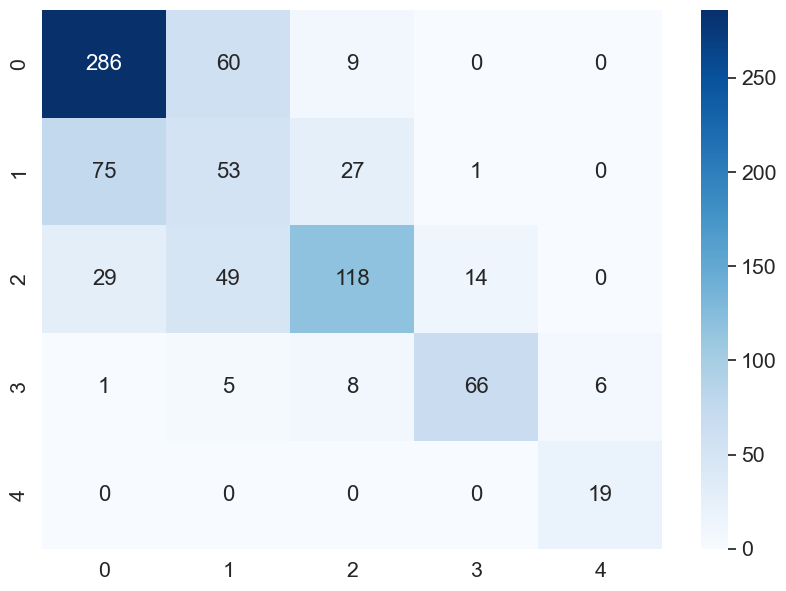

In [41]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
confusion = confusion_matrix(y.cpu(),csv['y_pred_svm'])
#confusion = confusion_matrix(df['y'],df['y_pred_rounded'])
df_cm = pd.DataFrame(confusion)
sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues") # font size

plt.show()

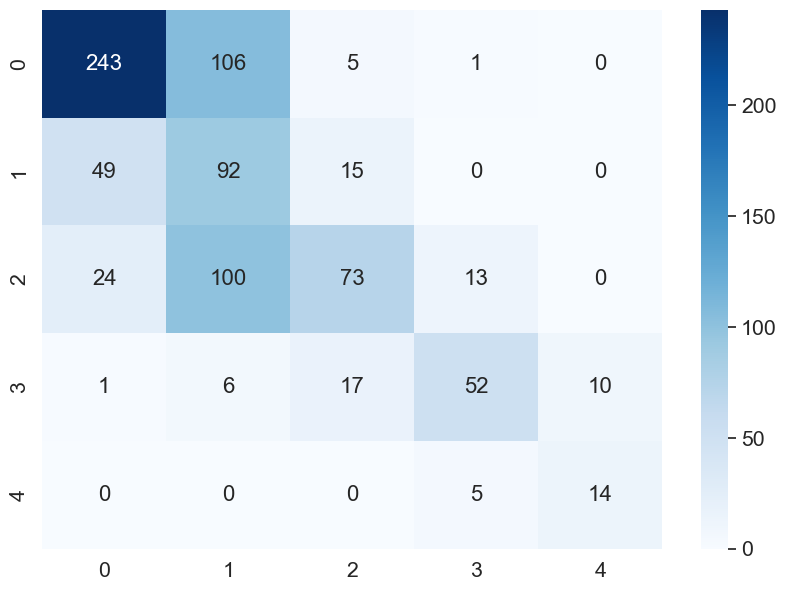

In [110]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
confusion = confusion_matrix(y.cpu(),y_pred_rounded.cpu())
#confusion = confusion_matrix(df['y'],df['y_pred_rounded'])
df_cm = pd.DataFrame(confusion)
sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues") # font size

plt.show()

In [111]:
from sklearn.metrics import classification_report
print(classification_report(csv['y'],y_pred_rounded.cpu(),target_names=['0','1','2','3','4']))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       355
           1       0.30      0.59      0.40       156
           2       0.66      0.35      0.46       210
           3       0.73      0.60      0.66        86
           4       0.58      0.74      0.65        19

    accuracy                           0.57       826
   macro avg       0.61      0.59      0.58       826
weighted avg       0.65      0.57      0.59       826



In [113]:
import pandas as pd
df=pd.read_csv("C:\\Users\\Michael\\Documents\\post_knee\\test\\efficientnet.csv")

In [114]:
df

,Unnamed: 0,filename,y,y_pred,y_pred_rounded,y_pred_svm
0,0,C:\Users\Michael\Documents\post_knee_all\2\972...,2.0,2.063838,2.0,2.0
1,1,C:\Users\Michael\Documents\post_knee_all\0\909...,0.0,0.429776,0.0,0.0
2,2,C:\Users\Michael\Documents\post_knee_all\1\940...,1.0,1.516402,2.0,2.0
3,3,C:\Users\Michael\Documents\post_knee_all\1\982...,1.0,0.391059,0.0,0.0
4,4,C:\Users\Michael\Documents\post_knee_all\0\971...,0.0,0.235867,0.0,0.0
...,...,...,...,...,...,...
821,821,C:\Users\Michael\Documents\post_knee_all\3\936...,3.0,3.088131,3.0,3.0
822,822,C:\Users\Michael\Documents\post_knee_all\3\934...,3.0,3.803669,4.0,3.0
823,823,C:\Users\Michael\Documents\post_knee_all\2\991...,2.0,1.802088,2.0,2.0
824,824,C:\Users\Michael\Documents\post_knee_all\2\974...,2.0,0.307741,0.0,0.0
